# Predictive Modeling using Multiple Logistic Regression in Python

### Analysis: Multiple Logistic Regression for Customer Behavior Prediction

This Python code analysis delves into the usage of predictive analytics, specifically applying multiple logistic regression for customer behavior prediction in terms of bandwidth usage. The primary objective is to employ proactive strategies to predict churn usage, thereby optimizing the customer experience. 

**The analysis seeks to test a hypothesis: Can we use logistic regression as an efficient tool to predict churn usage given a specific dataset?**

*This includes the Python code and data analysis, but it does not include the write-up that I wrote.*

## Jupyter Notebook and Python Version 
### The version of the notebook server is: 6.4.12
### The server is running on this version of Python: Python 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]


In [1]:
import matplotlib as plt
import pandas as pd
import numpy as np
from pandas import DataFrame
import pylab
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statistics 
import numpy as np
import pandas as pd
import seaborn as sns
 

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import logit 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


import warnings
warnings.filterwarnings('ignore') 


In [2]:
churndata = pd.read_csv('LogReg_Input.csv')

In [3]:
churndata.shape

(10000, 50)

## Look for duplicates

In [4]:
churndata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CaseOrder             10000 non-null  int64  
 1   Customer_id           10000 non-null  object 
 2   Interaction           10000 non-null  object 
 3   UID                   10000 non-null  object 
 4   City                  10000 non-null  object 
 5   State                 10000 non-null  object 
 6   County                10000 non-null  object 
 7   Zip                   10000 non-null  int64  
 8   Lat                   10000 non-null  float64
 9   Lng                   10000 non-null  float64
 10  Population            10000 non-null  int64  
 11  Area                  10000 non-null  object 
 12  TimeZone              10000 non-null  object 
 13  Job                   10000 non-null  object 
 14  Children              10000 non-null  int64  
 15  Age                 

## No duplicates found

In [5]:
churndata.duplicated().value_counts()

False    10000
dtype: int64

## Look for duplicates without the first 2 columns(those are unique)

In [6]:
churndata.duplicated().value_counts()

False    10000
dtype: int64

### There are absolutely NO duplicates


## Detection of Missing Data

### Listing of null data in the table

In [7]:
churndata.isnull().sum()

CaseOrder               0
Customer_id             0
Interaction             0
UID                     0
City                    0
State                   0
County                  0
Zip                     0
Lat                     0
Lng                     0
Population              0
Area                    0
TimeZone                0
Job                     0
Children                0
Age                     0
Income                  0
Marital                 0
Gender                  0
Churn                   0
Outage_sec_perweek      0
Email                   0
Contacts                0
Yearly_equip_failure    0
Techie                  0
Contract                0
Port_modem              0
Tablet                  0
InternetService         0
Phone                   0
Multiple                0
OnlineSecurity          0
OnlineBackup            0
DeviceProtection        0
TechSupport             0
StreamingTV             0
StreamingMovies         0
PaperlessBilling        0
PaymentMetho


The two methods of treating missing data are deletion and imputatuion.  

## Dealing with missing data

I created the NULLsubset so that we can specifically look at the data in only the fields with NULL data.

In [8]:
NULLsubset = churndata[[ 'Techie', 'Phone', 'Tenure', 'Bandwidth_GB_Year', 'Children', 'TechSupport', 'Age', 'Income' ]]

In [9]:
NULLsubset.isnull().sum()

Techie               0
Phone                0
Tenure               0
Bandwidth_GB_Year    0
Children             0
TechSupport          0
Age                  0
Income               0
dtype: int64

### Histograms of the NULL data 

array([[<Axes: title={'center': 'Tenure'}>,
        <Axes: title={'center': 'Bandwidth_GB_Year'}>],
       [<Axes: title={'center': 'Children'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'Income'}>, <Axes: >]], dtype=object)

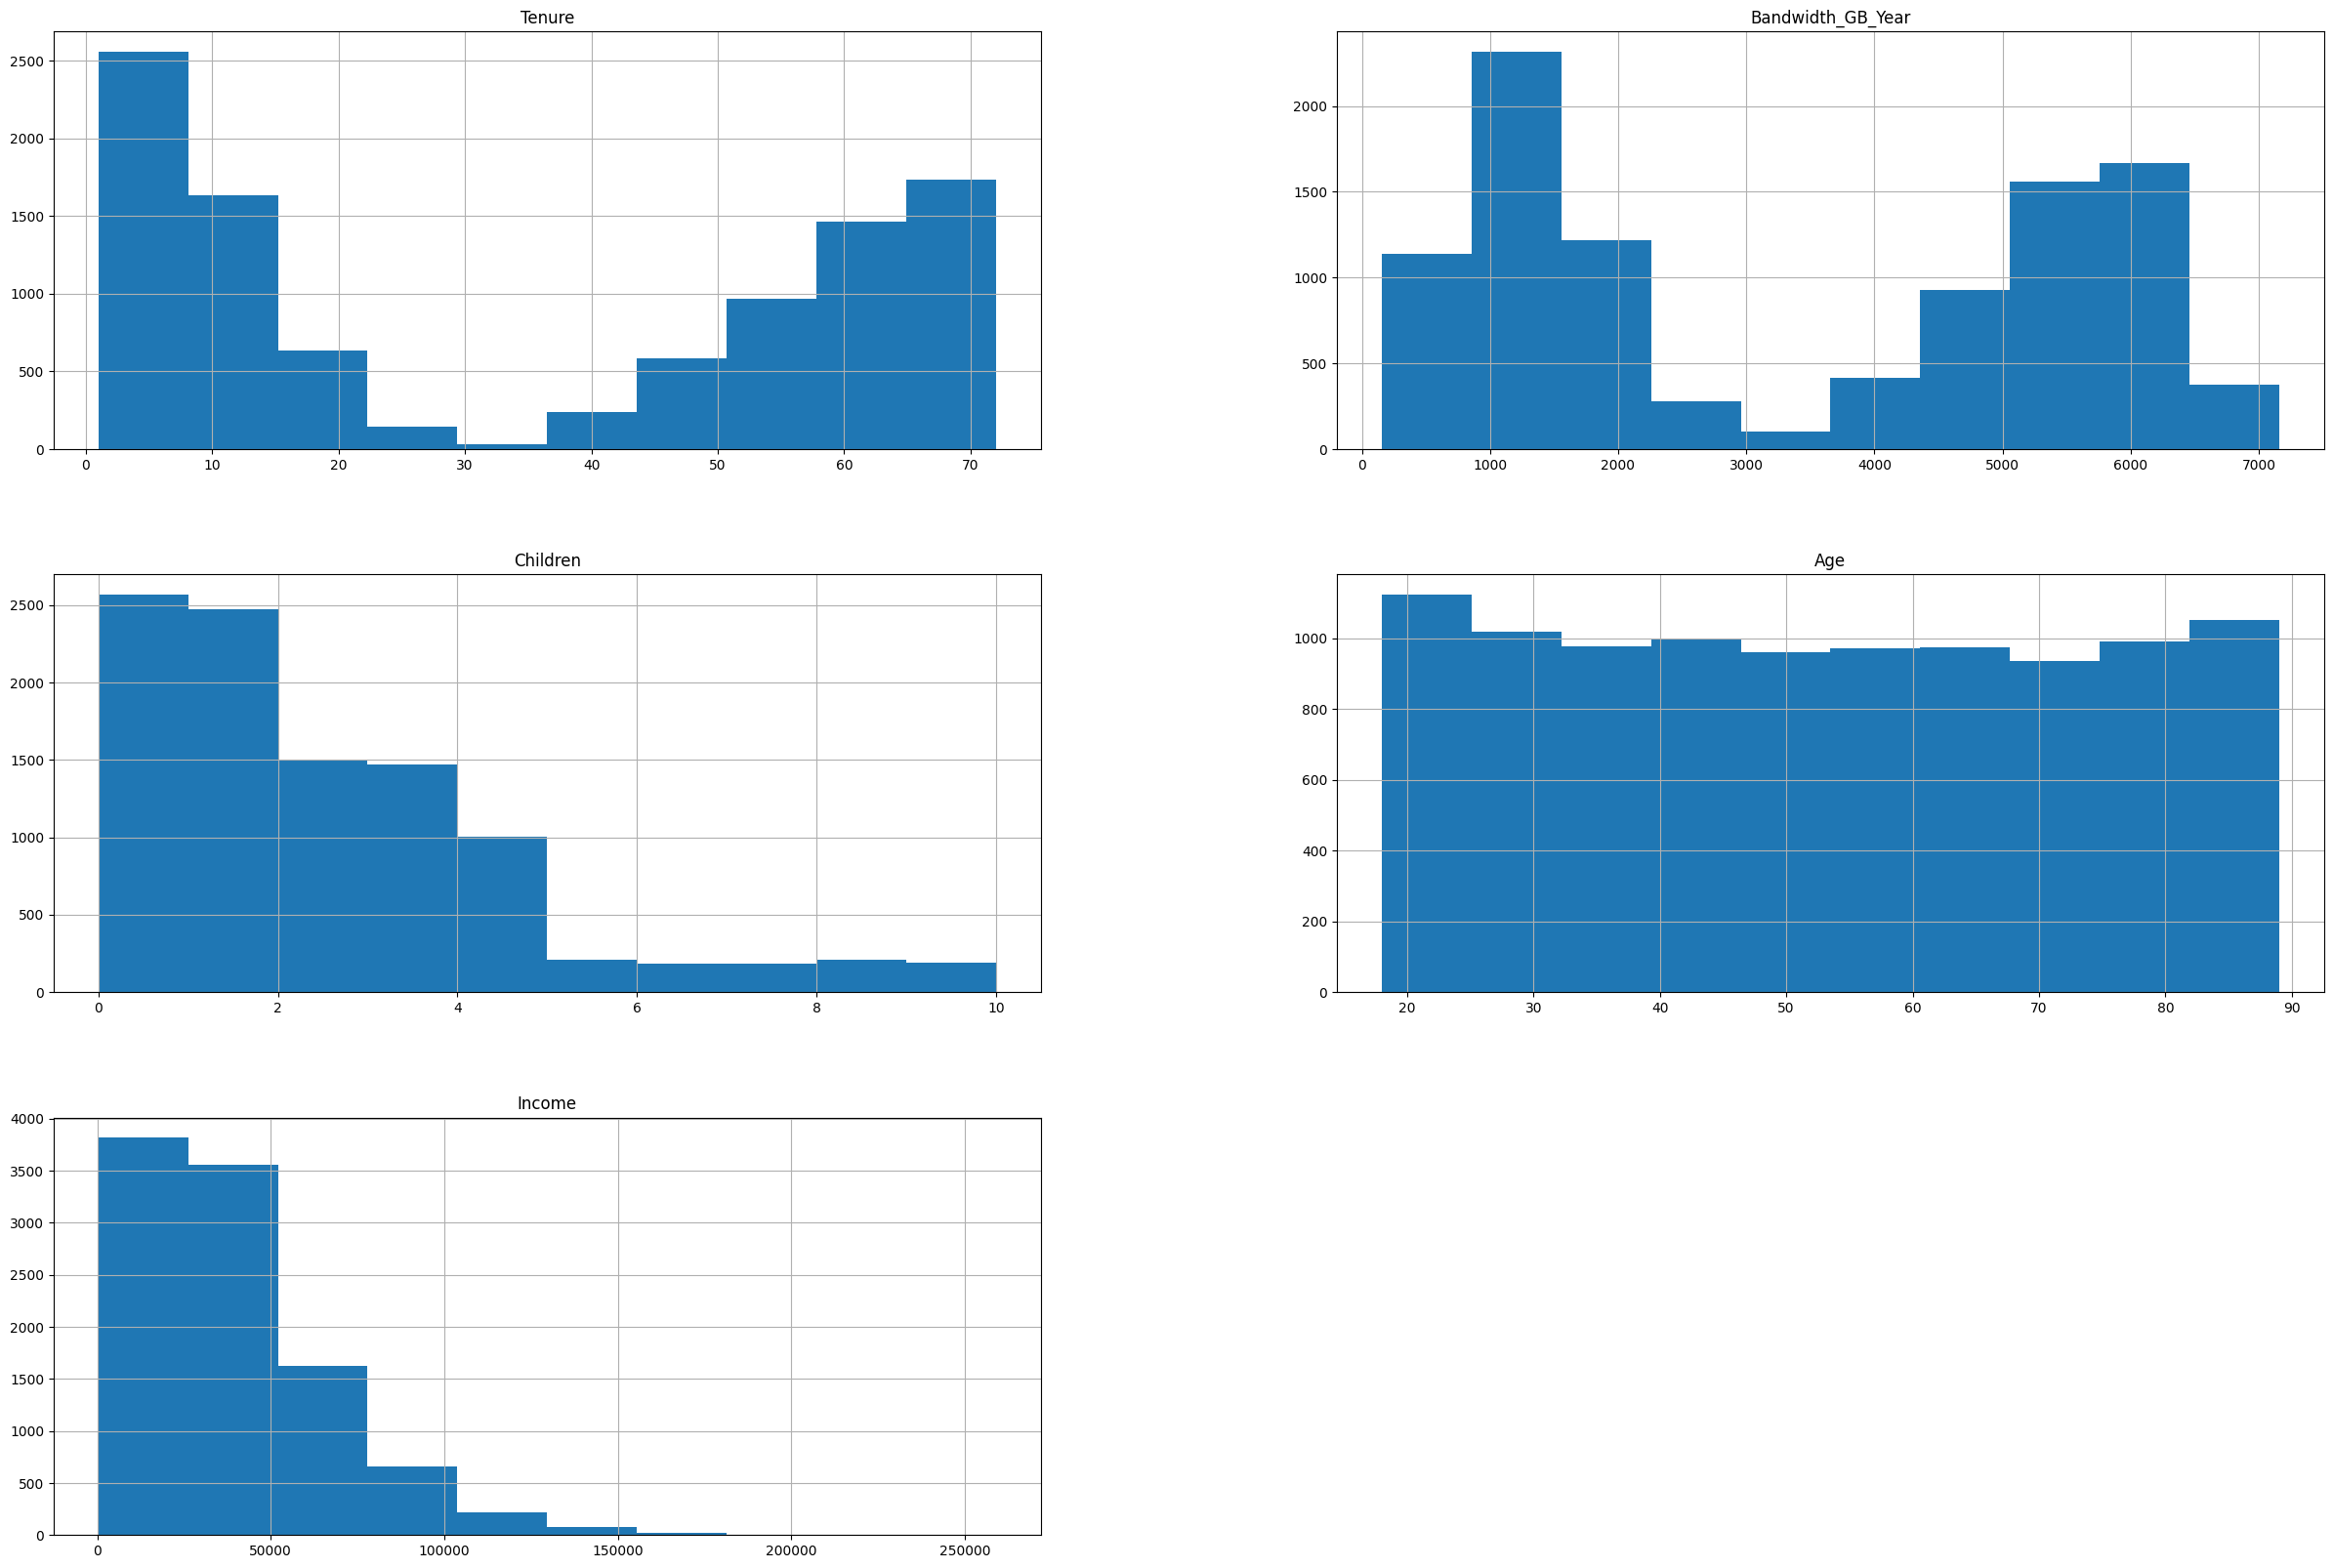

In [10]:
NULLsubset.hist(bins = 10, figsize=(30,20))

<Axes: >

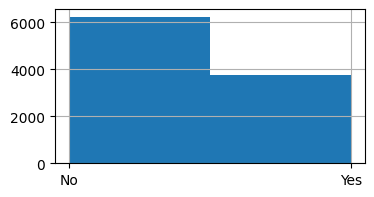

In [11]:
NULLsubset['TechSupport'].hist(bins = 2, figsize=(4,2))

<Axes: >

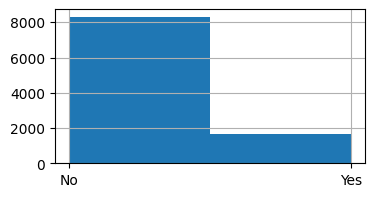

In [12]:
NULLsubset['Techie'].hist(bins = 2, figsize=(4,2))

<Axes: >

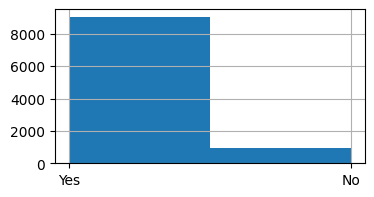

In [13]:
NULLsubset['Phone'].hist(bins = 2, figsize=(4,2))

### Basic information from the columns with NULL data.  The Phone and Techie columns will be dealt with later.  

In [14]:
NULLsubset.describe()

Tenure  Bandwidth_GB_Year    Children           Age  \
count  10000.000000       10000.000000  10000.0000  10000.000000   
mean      34.526188        3392.341550      2.0877     53.078400   
std       26.443063        2185.294852      2.1472     20.698882   
min        1.000259         155.506715      0.0000     18.000000   
25%        7.917694        1236.470827      0.0000     35.000000   
50%       35.430507        3279.536903      1.0000     53.000000   
75%       61.479795        5586.141370      3.0000     71.000000   
max       71.999280        7158.981530     10.0000     89.000000   

              Income  
count   10000.000000  
mean    39806.926771  
std     28199.916702  
min       348.670000  
25%     19224.717500  
50%     33170.605000  
75%     53246.170000  
max    258900.700000

### Overall interpretations of the graphs and treatment preference


I want to look at the distribution shapes of the seven columns with NULL data and the type of distributuon that each of those graphs has. I will be treating the missing data according to the primary method listed in the lecture based on the inital distribution of the data that contains the missing data.  I will include all of the code and proof that each of the columns with null values were imputed using the prefered treatment method in the sections below.


* The Children graph is positively skewed to the right.  The prefered imputation method for the skewed graph is to impute the median value for the NULL values.
* The Age graph has a uniform distribution meaning it is equally spread with no peaks. The Mean will be imputed for the missing  values since it is the prefered method of imputation for graphs with a uniform distribution.
* The Income graph is positively skewed to the right.  The prefered imputation method for the skewed graph is to impute the median value for the NULL values.
* The TechSupport graph shows that it is a yes no option and there are NULL values in addition. The prefered imputation method for cateforical data is to use the Mode value when imputing data for the NULL values.
* The Techie graph shows that it is a yes no option and there are NULL values in addition. The prefered imputation method for cateforical data is to use the Mode value when imputing data for the NULL values.
* The Phone graph shows that it is a yes no option and there are NULL values in addition.  The prefered imputation method for cateforical data is to use the Mode value when imputing data for the NULL values.
* The Tenure graph has a bimodal distribution and is non-symetric. The prefered imputation method for the skewed graph is to impute the median value for the NULL values.
* The Bandwidth_GB_Year has a bimodal distribution and is non-symetric.  This graph is a bit more symetric than the Tenure graph.  The prefered imputation method for the skewed graph is to impute the median value for the NULL values.





## Treating missing data


I will be treating the missing data according to the primary method listed in the lecture based on the inital distribution of the data that contains the missing data.  

### Children imputation
The Children graph is positively skewed to the right.  The prefered imputation method for the skewed graph is to impute the median value for the NULL values.


In [15]:
churndata["Children"].fillna(churndata["Children"].median(), inplace = True)

The median number of Children is 1.  After running the histogram, you can see that there is a spike at 1 that shows that all of the NULL values were replaced with 1.0.

In [16]:
print(churndata["Children"].median())

1.0


<Axes: >

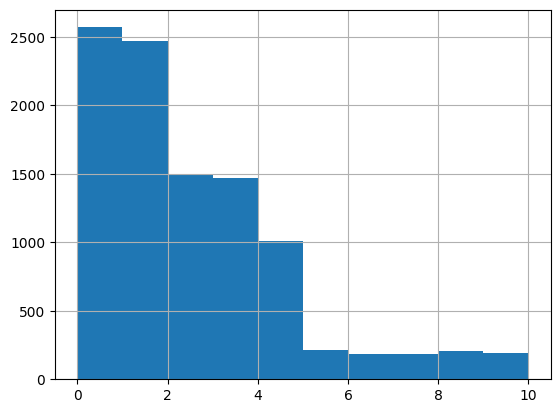

In [17]:
churndata['Children'].hist()

There are no fields in the Children column with NULL values.

In [18]:
churndata['Children'].isnull().sum()

0

### Age imputation

The Age graph has a uniform distribution meaning it is equally spread with no peaks. The Mean will be imputed for the missing  values since it is the prefered method of imputation for graphs with a uniform distribution.   

Since the mean of the Age column is 53.27574750830565, that value will be imputed  for all of the places there are NULL value in that column. To do this, I will use the Fillna function.

In [19]:
churndata["Age"].fillna(churndata["Age"].mean(), inplace = True)

After the Age NULL values were filled with the mean values, there is a difference in the graph with a spike at the Mean value.

<Axes: >

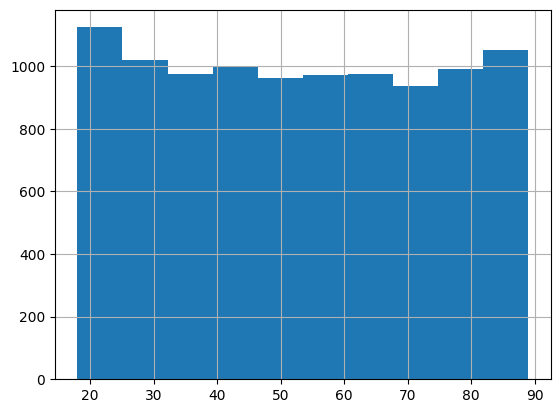

In [20]:
churndata['Age'].hist()

There are no NULL values in the Age column.

In [21]:
churndata['Age'].isnull().sum()

0

The Mean is still 53.275747508309024.

In [22]:
 churndata['Age'].mean()

53.0784

### Income imputation

The Income graph is positively skewed to the right.  The prefered imputation method for the skewed graph is to impute the median value for the NULL values.

In [23]:
print(churndata["Income"].median())

33170.604999999996


In [24]:
churndata["Income"].fillna(churndata["Income"].median(), inplace = True)

After the imputation, the graph is still positively skewed, but you can see a spike aroud the median value below 50,000 dollars. After imputation, the median is still $33,186.785 

<Axes: >

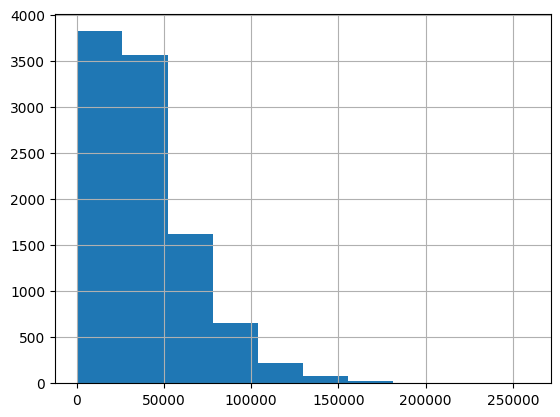

In [25]:
churndata['Income'].hist()

In [26]:
print(churndata["Income"].median())

33170.604999999996


There are no NULL values in the Income column.

In [27]:
churndata['Children'].isnull().sum()

0

### Tenure imputation

The Tenure graph has a bimodal distribution and is non-symetric. The prefered imputation method for the skewed graph is to impute the median value for the NULL values.


In [28]:
print(churndata["Tenure"].median())

35.430506995


In [29]:
churndata["Tenure"].fillna(churndata["Tenure"].median(), inplace = True)

After the imputation, the graph still has a bimodal distribuation that is non-symetric, but now there is a spike at the median value.  You can also see that there are now 0 NULL values in the Tenure column.

<Axes: >

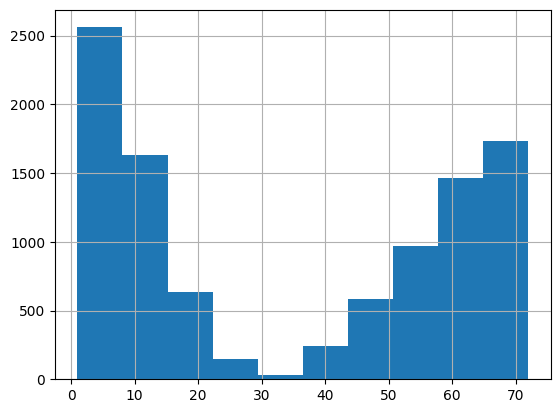

In [30]:
churndata['Tenure'].hist()

In [31]:
churndata['Tenure'].isnull().sum()

0

### Bandwidth_GB_Year imputation

The Bandwidth_GB_Year has a bimodal distribution and is non-symetric.  This graph is a bit more symetric than the Tenure graph.  The prefered imputation method for the skewed graph is to impute the median value for the NULL values.


In [32]:
print(churndata["Bandwidth_GB_Year"].median())

3279.536903


In [33]:
churndata["Bandwidth_GB_Year"].fillna(churndata["Bandwidth_GB_Year"].median(), inplace = True)

<Axes: >

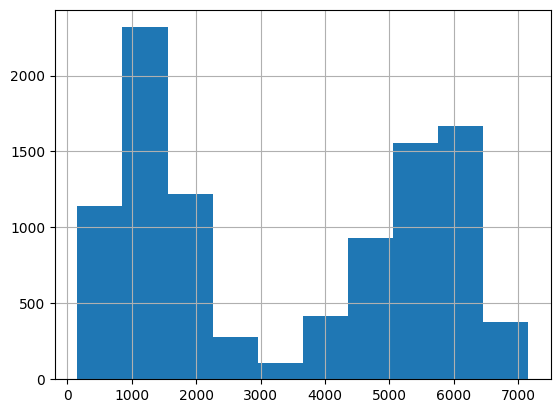

In [34]:
churndata['Bandwidth_GB_Year'].hist()

After the imputation, the graph still has a bimodal distribuation that is non-symetric, but now there is a spike at the median value.  You can also see that there are now 0 NULL values in the Tenure column.

In [35]:
churndata['Bandwidth_GB_Year'].isnull().sum()

0

## TechSupport imputation

In [36]:
print(churndata['TechSupport'].mode())

0    No
Name: TechSupport, dtype: object


In [37]:
churndata['TechSupport'] = churndata['TechSupport'].fillna(churndata['TechSupport'].mode()[0])

The TechSupport graph shows that it is a yes/no option and there are no NULL values in after the imputation. The prefered imputation method for categorical data is to use the Mode value when imputing data for the NULL values. 



<Axes: >

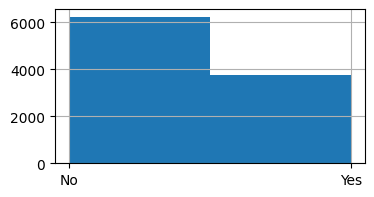

In [38]:
churndata['TechSupport'].hist(bins = 2, figsize=(4,2))

In [39]:
churndata['TechSupport'].isnull().sum()

0

### Techie imputation

The Techie graph shows that it is a yes/no option and there are NULL values in addition. The prefered imputation method for cateforical data is to use the Mode value when imputing data for the NULL values.



In [40]:
print(churndata['Techie'].mode())

0    No
Name: Techie, dtype: object


In [41]:

churndata['Techie'] = churndata['Techie'].fillna(churndata['Techie'].mode()[0])

After the imputation, the graph still has changed a bit and there are more values at the mode value of 0. You can also see that there are now 0 NULL values in the Techie column.

<Axes: >

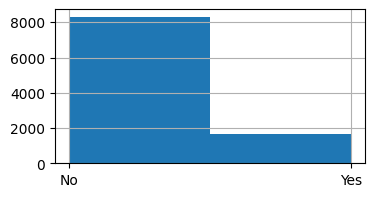

In [42]:
churndata['Techie'].hist(bins = 2, figsize=(4,2))

In [43]:
churndata['Techie'].isnull().sum()

0

### Phone imputation

The Phone graph shows that it is a yes no option and there are NULL values in addition.  The prefered imputation method for categorical data is to use the Mode value when imputing data for the NULL values.


In [44]:
print(churndata['Phone'].mode())

0    Yes
Name: Phone, dtype: object


In [45]:
churndata['Phone'] = churndata['Phone'].fillna(churndata['Phone'].mode()[0])

After the imputation, the graph still has changed a bit and there are more values at the mode value of 0. You can also see that there are now 0 NULL values in the Phone column.

<Axes: >

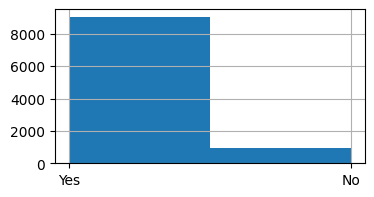

In [46]:
churndata['Phone'].hist(bins = 2, figsize=(4,2))

In [47]:
churndata['Phone'].isnull().sum()

0

### All NULL values from each column have been imputed.

In [48]:
churndata.isnull().sum()

CaseOrder               0
Customer_id             0
Interaction             0
UID                     0
City                    0
State                   0
County                  0
Zip                     0
Lat                     0
Lng                     0
Population              0
Area                    0
TimeZone                0
Job                     0
Children                0
Age                     0
Income                  0
Marital                 0
Gender                  0
Churn                   0
Outage_sec_perweek      0
Email                   0
Contacts                0
Yearly_equip_failure    0
Techie                  0
Contract                0
Port_modem              0
Tablet                  0
InternetService         0
Phone                   0
Multiple                0
OnlineSecurity          0
OnlineBackup            0
DeviceProtection        0
TechSupport             0
StreamingTV             0
StreamingMovies         0
PaperlessBilling        0
PaymentMetho

### Update the CSV file with imputed data.

In [49]:
churndata.to_csv('LogReg_TreatedData.csv')

# Data Wrangling

 ## Code to change the column names of items1 through items8

In [50]:
churndata.rename(columns={'Item1':'TimelyResponse'}, inplace=True)

In [51]:
churndata.TimelyResponse.unique()

array([5, 3, 4, 6, 2, 1, 7], dtype=int64)

In [52]:
churndata.rename(columns={'Item2':'TimelyFixes'}, inplace=True)

In [53]:
churndata.TimelyFixes


0       5
1       4
2       4
3       4
4       4
       ..
9995    2
9996    5
9997    4
9998    4
9999    2
Name: TimelyFixes, Length: 10000, dtype: int64

In [54]:
## TODO  what is happening here?
churndata.TimelyFixes.unique()

array([5, 4, 3, 2, 6, 1, 7], dtype=int64)

In [55]:
churndata.rename(columns={'Item3':'TimelyReplacements'}, inplace=True)

In [56]:
churndata.TimelyReplacements.unique()

array([5, 3, 2, 4, 6, 1, 7, 8], dtype=int64)

In [57]:
churndata.rename(columns={'Item4':'Reliability'}, inplace=True)

In [58]:
churndata.Reliability.unique()

array([3, 4, 2, 5, 7, 6, 1], dtype=int64)

In [59]:
churndata.rename(columns={'Item5':'Options'}, inplace=True)

In [60]:
churndata.Options.unique()

array([4, 5, 1, 2, 3, 7, 6], dtype=int64)

In [61]:
churndata.rename(columns={'Item6':'RespectfulResponse'}, inplace=True)

In [62]:
churndata

CaseOrder Customer_id                           Interaction  \
0             1     K409198  aa90260b-4141-4a24-8e36-b04ce1f4f77b   
1             2     S120509  fb76459f-c047-4a9d-8af9-e0f7d4ac2524   
2             3     K191035  344d114c-3736-4be5-98f7-c72c281e2d35   
3             4      D90850  abfa2b40-2d43-4994-b15a-989b8c79e311   
4             5     K662701  68a861fd-0d20-4e51-a587-8a90407ee574   
...         ...         ...                                   ...   
9995       9996     M324793  45deb5a2-ae04-4518-bf0b-c82db8dbe4a4   
9996       9997     D861732  6e96b921-0c09-4993-bbda-a1ac6411061a   
9997       9998     I243405  e8307ddf-9a01-4fff-bc59-4742e03fd24f   
9998       9999     I641617  3775ccfc-0052-4107-81ae-9657f81ecdf3   
9999      10000      T38070  9de5fb6e-bd33-4995-aec8-f01d0172a499   

                                   UID          City State  \
0     e885b299883d4f9fb18e39c75155d990   Point Baker    AK   
1     f2de8bef964785f41a2959829830fb8a   West Branch    MI   
2     f1784cfa9f6d92ae816197eb175d3c71       Yamhill    OR   
3     dc8a365077241bb5cd5ccd305136b05e       Del Mar    CA   
4     aabb64a116e83fdc4befc1fbab1663f9     Needville    TX   
...                                ...           ...   ...   
9995  9499fb4de537af195d16d046b79fd20a   Mount Holly    VT   
9996  c09a841117fa81b5c8e19afec2760104   Clarksville    TN   
9997  9c41f212d1e04dca84445019bbc9b41c      Mobeetie    TX   
9998  3e1f269b40c235a1038863ecf6b7a0df    Carrollton    GA   
9999  0ea683a03a3cd544aefe8388aab16176  Clarkesville    GA   

                     County    Zip       Lat        Lng  ...  MonthlyCharge  \
0     Prince of Wales-Hyder  99927  56.25100 -133.37571  ...     172.455519   
1                    Ogemaw  48661  44.32893  -84.24080  ...     242.632554   
2                   Yamhill  97148  45.35589 -123.24657  ...     159.947583   
3                 San Diego  92014  32.96687 -117.24798  ...     119.956840   
4                 Fort Bend  77461  29.38012  -95.80673  ...     149.948316   
...                     ...    ...       ...        ...  ...            ...   
9995                Rutland   5758  43.43391  -72.78734  ...     159.979400   
9996             Montgomery  37042  36.56907  -87.41694  ...     207.481100   
9997                Wheeler  79061  35.52039 -100.44180  ...     169.974100   
9998                Carroll  30117  33.58016  -85.13241  ...     252.624000   
9999              Habersham  30523  34.70783  -83.53648  ...     217.484000   

     Bandwidth_GB_Year TimelyResponse TimelyFixes  TimelyReplacements  \
0           904.536110              5           5                   5   
1           800.982766              3           4                   3   
2          2054.706961              4           4                   2   
3          2164.579412              4           4                   4   
4           271.493436              4           4                   4   
...                ...            ...         ...                 ...   
9995       6511.252601              3           2                   3   
9996       5695.951810              4           5                   5   
9997       4159.305799              4           4                   4   
9998       6468.456752              4           4                   6   
9999       5857.586167              2           2                   3   

      Reliability  Options RespectfulResponse Item7 Item8  
0               3        4                  4     3     4  
1               3        4                  3     4     4  
2               4        4                  3     3     3  
3               2        5                  4     3     3  
4               3        4                  4     4     5  
...           ...      ...                ...   ...   ...  
9995            3        4                  3     2     3  
9996            4        4                  5     2     5  
9997            4        4                  4     4     5  
9998  

In [63]:
 
churndata.RespectfulResponse.unique()

array([4, 3, 5, 2, 6, 7, 1, 8], dtype=int64)

In [64]:
churndata.rename(columns={'Item7':'CourteousExchange'}, inplace=True)

In [65]:
churndata.CourteousExchange.unique()

array([3, 4, 5, 2, 6, 7, 1], dtype=int64)

In [66]:
churndata.rename(columns={'Item8':'ActiveListening'}, inplace=True)

In [67]:
churndata.ActiveListening.unique()

array([4, 3, 5, 2, 1, 6, 7, 8], dtype=int64)

In [68]:
 LOGdata = churndata[['Churn',  'Techie',  'Multiple','Contract' ,'Options',   'Tenure', 'StreamingTV', 'StreamingMovies', 'MonthlyCharge', 'Bandwidth_GB_Year', ]]

The column names were changed.

In [69]:
churndata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CaseOrder             10000 non-null  int64  
 1   Customer_id           10000 non-null  object 
 2   Interaction           10000 non-null  object 
 3   UID                   10000 non-null  object 
 4   City                  10000 non-null  object 
 5   State                 10000 non-null  object 
 6   County                10000 non-null  object 
 7   Zip                   10000 non-null  int64  
 8   Lat                   10000 non-null  float64
 9   Lng                   10000 non-null  float64
 10  Population            10000 non-null  int64  
 11  Area                  10000 non-null  object 
 12  TimeZone              10000 non-null  object 
 13  Job                   10000 non-null  object 
 14  Children              10000 non-null  int64  
 15  Age                 

### Update the CSV file to include column name changes

In [70]:
churndata.to_csv('LogReg_TreatedData.csv')

## Make Customer_id the index for the table.

In [71]:
churndata.set_index('Customer_id')

CaseOrder                           Interaction  \
Customer_id                                                    
K409198              1  aa90260b-4141-4a24-8e36-b04ce1f4f77b   
S120509              2  fb76459f-c047-4a9d-8af9-e0f7d4ac2524   
K191035              3  344d114c-3736-4be5-98f7-c72c281e2d35   
D90850               4  abfa2b40-2d43-4994-b15a-989b8c79e311   
K662701              5  68a861fd-0d20-4e51-a587-8a90407ee574   
...                ...                                   ...   
M324793           9996  45deb5a2-ae04-4518-bf0b-c82db8dbe4a4   
D861732           9997  6e96b921-0c09-4993-bbda-a1ac6411061a   
I243405           9998  e8307ddf-9a01-4fff-bc59-4742e03fd24f   
I641617           9999  3775ccfc-0052-4107-81ae-9657f81ecdf3   
T38070           10000  9de5fb6e-bd33-4995-aec8-f01d0172a499   

                                          UID          City State  \
Customer_id                                                         
K409198      e885b299883d4f9fb18e39c75155d990   Point Baker    AK   
S120509      f2de8bef964785f41a2959829830fb8a   West Branch    MI   
K191035      f1784cfa9f6d92ae816197eb175d3c71       Yamhill    OR   
D90850       dc8a365077241bb5cd5ccd305136b05e       Del Mar    CA   
K662701      aabb64a116e83fdc4befc1fbab1663f9     Needville    TX   
...                                       ...           ...   ...   
M324793      9499fb4de537af195d16d046b79fd20a   Mount Holly    VT   
D861732      c09a841117fa81b5c8e19afec2760104   Clarksville    TN   
I243405      9c41f212d1e04dca84445019bbc9b41c      Mobeetie    TX   
I641617      3e1f269b40c235a1038863ecf6b7a0df    Carrollton    GA   
T38070       0ea683a03a3cd544aefe8388aab16176  Clarkesville    GA   

                            County    Zip       Lat        Lng  Population  \
Customer_id                                                                  
K409198      Prince of Wales-Hyder  99927  56.25100 -133.37571          38   
S120509                     Ogemaw  48661  44.32893  -84.24080       10446   
K191035                    Yamhill  97148  45.35589 -123.24657        3735   
D90850                   San Diego  92014  32.96687 -117.24798       13863   
K662701                  Fort Bend  77461  29.38012  -95.80673       11352   
...                            ...    ...       ...        ...         ...   
M324793                    Rutland   5758  43.43391  -72.78734         640   
D861732                 Montgomery  37042  36.56907  -87.41694       77168   
I243405                    Wheeler  79061  35.52039 -100.44180         406   
I641617                    Carroll  30117  33.58016  -85.13241       35575   
T38070                   Habersham  30523  34.70783  -83.53648       12230   

             ... MonthlyCharge Bandwidth_GB_Year TimelyResponse  TimelyFixes  \
Customer_id  ...                                                               
K409198      ...    172.455519        904.536110              5            5   
S120509      ...    242.632554        800.982766              3            4   
K191035      ...    159.947583       2054.706961              4            4   
D90850       ...    119.956840       2164.579412              4            4   
K662701      ...    149.948316        271.493436              4            4   
...          ...           ...               ...            ...          ...   
M324793      ...    159.979400       6511.252601              3            2   
D861732      ...    207.481100       5695.951810              4            5   
I243405      ...    169.974100       4159.305799              4            4   
I641617      ...    252.624000       6468.456752              4            4   
T38070       ...    217.484000       5857.586167              2            2   

             TimelyReplacements  Reliability Options RespectfulResponse  \
Customer_id                                                               
K409198                       5            3       4                  4   
S

You can see that the index for the table is now Customer_id.

In [72]:
display(churndata.isnull().any())

CaseOrder               False
Customer_id             False
Interaction             False
UID                     False
City                    False
State                   False
County                  False
Zip                     False
Lat                     False
Lng                     False
Population              False
Area                    False
TimeZone                False
Job                     False
Children                False
Age                     False
Income                  False
Marital                 False
Gender                  False
Churn                   False
Outage_sec_perweek      False
Email                   False
Contacts                False
Yearly_equip_failure    False
Techie                  False
Contract                False
Port_modem              False
Tablet                  False
InternetService         False
Phone                   False
Multiple                False
OnlineSecurity          False
OnlineBackup            False
DeviceProt

### prints out a correlation matrix

In [73]:
display(churndata.corr())

CaseOrder           Zip       Lat       Lng  Population  \
CaseOrder              1.000000  3.007020e-03 -0.014680 -0.001363   -0.007494   
Zip                    0.003007  1.000000e+00 -0.042580 -0.901786    0.045138   
Lat                   -0.014680 -4.257985e-02  1.000000 -0.100639   -0.220598   
Lng                   -0.001363 -9.017856e-01 -0.100639  1.000000   -0.048294   
Population            -0.007494  4.513808e-02 -0.220598 -0.048294    1.000000   
Children              -0.006148 -1.720505e-02 -0.000452  0.013634   -0.005877   
Age                    0.016038 -8.135285e-03 -0.002943  0.012117    0.010538   
Income                 0.000192  2.946523e-03  0.006563 -0.002997   -0.008639   
Outage_sec_perweek    -0.001358 -1.152040e-02  0.004827  0.005646    0.005483   
Email                 -0.011274 -7.860018e-03 -0.030042  0.007872    0.017962   
Contacts               0.004361 -4.719513e-03 -0.002213  0.008118    0.004019   
Yearly_equip_failure   0.005497  1.104692e-02 -0.007125 -0.005577   -0.004483   
Tenure                 0.832550 -3.227133e-03 -0.015743  0.003618   -0.003559   
MonthlyCharge          0.003677 -8.716780e-03  0.001406  0.011765   -0.004778   
Bandwidth_GB_Year      0.825561 -2.527196e-03 -0.016949  0.003446   -0.003902   
TimelyResponse        -0.004318 -2.602437e-02  0.005793  0.024389    0.000618   
TimelyFixes            0.005959 -3.215486e-03  0.005380  0.003024   -0.002571   
TimelyReplacements     0.003245 -1.968673e-02 -0.003421  0.014966    0.001620   
Reliability           -0.005641  6.196497e-07  0.011015 -0.002398   -0.008272   
Options                0.016429  2.922689e-03 -0.000464  0.001366    0.006970   
RespectfulResponse    -0.007837  7.375053e-03 -0.008726 -0.008770    0.000834   
CourteousExchange      0.003595 -5.537247e-03  0.006087  0.001601   -0.013062   
ActiveListening       -0.014840 -2.577073e-03 -0.019583  0.001912    0.008524   

                      Children       Age    Income  Outage_sec_perweek  \
CaseOrder            -0.006148  0.016038  0.000192           -0.001358   
Zip                  -0.017205 -0.008135  0.002947           -0.011520   
Lat                  -0.000452 -0.002943  0.006563            0.004827   
Lng                   0.013634  0.012117 -0.002997            0.005646   
Population           -0.005877  0.010538 -0.008639            0.005483   
Children              1.000000 -0.029732  0.009942            0.001889   
Age                  -0.029732  1.000000 -0.004091           -0.008047   
Income                0.009942 -0.004091  1.000000           -0.010011   
Outage_sec_perweek    0.001889 -0.008047 -0.010011            1.000000   
Email                 0.004479  0.001588 -0.009267            0.003994   
Contacts             -0.020776  0.015068  0.001233            0.015092   
Yearly_equip_failure  0.007321  0.008577  0.005423            0.002909   
Tenure               -0.005091  0.016979  0.002114            0.002932   
MonthlyCharge        -0.009781  0.010729 -0.003014            0.020496   
Bandwidth_GB_Year     0.025585 -0.014724  0.003674            0.004176   
TimelyResponse        0.011470 -0.005972 -0.004009           -0.023338   
TimelyFixes           0.013146  0.006659  0.007718           -0.008076   
TimelyReplacements    0.003394 -0.003778 -0.002707           -0.021366   
Reliability          -0.016768  0.012237 -0.022750           -0.005992   
Options              -0.000240 -0.008305  0.011111           -0.004156   
RespectfulResponse   -0.000547  0.010635  0.001768           -0.014752   
CourteousExchange     0.000687  0.005353  0.016599           -0.020854   
ActiveListening      -0.005236  0.015193  0.000740            0.008126   

                         Email  ...  MonthlyCharge  Bandwidth_GB_Year  \
CaseOrder            -0.011274  ...       0.003677           0.825561   
Zip                  -0.007860  ...      -0.008717          -0.002527   
Lat                  -0.030042  ...       0.001406          -0.016949   
Lng     

In [74]:
churndata.Churn

0        No
1       Yes
2        No
3        No
4       Yes
       ... 
9995     No
9996     No
9997     No
9998     No
9999     No
Name: Churn, Length: 10000, dtype: object

In [75]:
## Correlation Matrix

<Axes: >

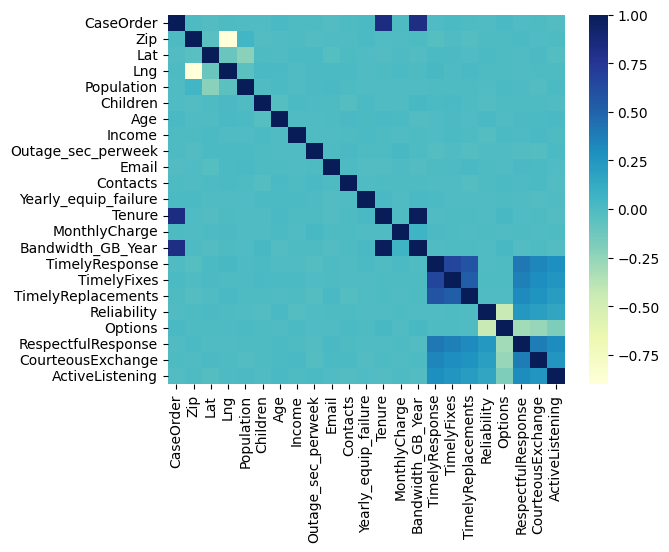

In [76]:
sns.heatmap(churndata.corr(),xticklabels =churndata.corr().columns, cmap='YlGnBu' )

In [77]:
#why isn't churn showing up on corr matrix

# D208 Wrangling

Define LOGdata

In [78]:
#LOGdata = churndata[['Churn',  'Techie',  'Multiple','Contract' ,'Options',   'Tenure', 'StreamingTV', 'StreamingMovies', 'MonthlyCharge', 'Bandwidth_GB_Year', ]]
#move to after wrangling

In [79]:
churndata


CaseOrder Customer_id                           Interaction  \
0             1     K409198  aa90260b-4141-4a24-8e36-b04ce1f4f77b   
1             2     S120509  fb76459f-c047-4a9d-8af9-e0f7d4ac2524   
2             3     K191035  344d114c-3736-4be5-98f7-c72c281e2d35   
3             4      D90850  abfa2b40-2d43-4994-b15a-989b8c79e311   
4             5     K662701  68a861fd-0d20-4e51-a587-8a90407ee574   
...         ...         ...                                   ...   
9995       9996     M324793  45deb5a2-ae04-4518-bf0b-c82db8dbe4a4   
9996       9997     D861732  6e96b921-0c09-4993-bbda-a1ac6411061a   
9997       9998     I243405  e8307ddf-9a01-4fff-bc59-4742e03fd24f   
9998       9999     I641617  3775ccfc-0052-4107-81ae-9657f81ecdf3   
9999      10000      T38070  9de5fb6e-bd33-4995-aec8-f01d0172a499   

                                   UID          City State  \
0     e885b299883d4f9fb18e39c75155d990   Point Baker    AK   
1     f2de8bef964785f41a2959829830fb8a   West Branch    MI   
2     f1784cfa9f6d92ae816197eb175d3c71       Yamhill    OR   
3     dc8a365077241bb5cd5ccd305136b05e       Del Mar    CA   
4     aabb64a116e83fdc4befc1fbab1663f9     Needville    TX   
...                                ...           ...   ...   
9995  9499fb4de537af195d16d046b79fd20a   Mount Holly    VT   
9996  c09a841117fa81b5c8e19afec2760104   Clarksville    TN   
9997  9c41f212d1e04dca84445019bbc9b41c      Mobeetie    TX   
9998  3e1f269b40c235a1038863ecf6b7a0df    Carrollton    GA   
9999  0ea683a03a3cd544aefe8388aab16176  Clarkesville    GA   

                     County    Zip       Lat        Lng  ...  MonthlyCharge  \
0     Prince of Wales-Hyder  99927  56.25100 -133.37571  ...     172.455519   
1                    Ogemaw  48661  44.32893  -84.24080  ...     242.632554   
2                   Yamhill  97148  45.35589 -123.24657  ...     159.947583   
3                 San Diego  92014  32.96687 -117.24798  ...     119.956840   
4                 Fort Bend  77461  29.38012  -95.80673  ...     149.948316   
...                     ...    ...       ...        ...  ...            ...   
9995                Rutland   5758  43.43391  -72.78734  ...     159.979400   
9996             Montgomery  37042  36.56907  -87.41694  ...     207.481100   
9997                Wheeler  79061  35.52039 -100.44180  ...     169.974100   
9998                Carroll  30117  33.58016  -85.13241  ...     252.624000   
9999              Habersham  30523  34.70783  -83.53648  ...     217.484000   

     Bandwidth_GB_Year TimelyResponse TimelyFixes  TimelyReplacements  \
0           904.536110              5           5                   5   
1           800.982766              3           4                   3   
2          2054.706961              4           4                   2   
3          2164.579412              4           4                   4   
4           271.493436              4           4                   4   
...                ...            ...         ...                 ...   
9995       6511.252601              3           2                   3   
9996       5695.951810              4           5                   5   
9997       4159.305799              4           4                   4   
9998       6468.456752              4           4                   6   
9999       5857.586167              2           2                   3   

      Reliability  Options RespectfulResponse CourteousExchange  \
0               3        4                  4                 3   
1               3        4                  3                 4   
2               4        4                  3                 3   
3               2        5                  4                 3   
4               3        4                  4                 4   
...           ...      ...                ...               ...   
9995            3        4                  3                 2   
9996            4        4                  5                 2   
999

In [80]:
LOGdata.isnull().sum()

Churn                0
Techie               0
Multiple             0
Contract             0
Options              0
Tenure               0
StreamingTV          0
StreamingMovies      0
MonthlyCharge        0
Bandwidth_GB_Year    0
dtype: int64

## Mean, median and mode for the predictor and target variable

In [81]:
LOGdata.describe()
 

Options        Tenure  MonthlyCharge  Bandwidth_GB_Year
count  10000.000000  10000.000000   10000.000000       10000.000000
mean       3.492900     34.526188     172.624816        3392.341550
std        1.024819     26.443063      42.943094        2185.294852
min        1.000000      1.000259      79.978860         155.506715
25%        3.000000      7.917694     139.979239        1236.470827
50%        3.000000     35.430507     167.484700        3279.536903
75%        4.000000     61.479795     200.734725        5586.141370
max        7.000000     71.999280     290.160419        7158.981530

# Data Wrangling

### Contacts

In [82]:
churndata.Contacts.unique()

array([0, 2, 3, 1, 4, 5, 6, 7], dtype=int64)

### Yearly_equip_failure    

In [83]:
churndata.Yearly_equip_failure.unique()

array([1, 0, 3, 2, 4, 6], dtype=int64)

## Categorical to Ordinal or Nominal

### Contract type

In [84]:
churndata.Contract.unique()


array(['One year', 'Month-to-month', 'Two Year'], dtype=object)

In [85]:

churndata.Contract.replace(['Month-to-month','One year', 'Two Year'], [0, 1, 2], inplace=True)

churndata.Contract.unique()

array([1, 0, 2], dtype=int64)

### Internet Service  

In [86]:
churndata.InternetService.unique()

array(['Fiber Optic', 'DSL', 'None'], dtype=object)

In [87]:
churndata.InternetService.replace([ 'None', 'DSL', 'Fiber Optic'], [0, 1, 2], inplace=True)

churndata.InternetService.unique()

array([2, 1, 0], dtype=int64)

## No/Yes to 0/1

In [88]:
churndata.Churn.unique()

array(['No', 'Yes'], dtype=object)

In [89]:
churndata.Churn.replace(['No', 'Yes'], [0, 1], inplace=True)

churndata.Churn.unique()

array([0, 1], dtype=int64)

In [90]:
 churndata.Churn

0       0
1       1
2       0
3       0
4       1
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: Churn, Length: 10000, dtype: int64

### Techie    

In [91]:
churndata.Techie.unique()

array(['No', 'Yes'], dtype=object)

In [92]:
churndata.Techie.replace(['No', 'Yes'], [0, 1], inplace=True)

churndata.Techie.unique()

array([0, 1], dtype=int64)

              
             
### Port_modem     

In [93]:
churndata.Port_modem 


0       Yes
1        No
2       Yes
3        No
4       Yes
       ... 
9995    Yes
9996     No
9997     No
9998     No
9999    Yes
Name: Port_modem, Length: 10000, dtype: object

In [94]:
churndata.Port_modem.replace(['No', 'Yes'], [0, 1], inplace=True)

churndata.Port_modem.unique()


array([1, 0], dtype=int64)

         
### Tablet            

In [95]:
churndata.Tablet.unique()

array(['Yes', 'No'], dtype=object)

In [96]:
churndata.Tablet.replace(['No', 'Yes'], [0, 1], inplace=True)

churndata.Tablet.unique()

array([1, 0], dtype=int64)

       
### Phone         

In [97]:
churndata.Phone.unique()

array(['Yes', 'No'], dtype=object)

In [98]:
churndata.Phone.replace(['No', 'Yes'], [0, 1], inplace=True)

churndata.Phone.unique()

array([1, 0], dtype=int64)

          
### Multiple    

In [99]:
churndata.Multiple.unique()

array(['No', 'Yes'], dtype=object)

In [100]:
churndata.Multiple.replace(['No', 'Yes'], [0, 1], inplace=True)

churndata.Multiple.unique()

array([0, 1], dtype=int64)

            
### OnlineSecurity    

In [101]:
churndata.OnlineSecurity.unique()

array(['Yes', 'No'], dtype=object)

In [102]:
churndata.OnlineSecurity.replace(['No', 'Yes'], [0, 1], inplace=True)

churndata.OnlineSecurity.unique()

array([1, 0], dtype=int64)

      
### OnlineBackup           ###  

In [103]:
churndata.OnlineBackup.unique()

array(['Yes', 'No'], dtype=object)

In [104]:
churndata.OnlineBackup.replace(['No', 'Yes'], [0, 1], inplace=True)

churndata.OnlineBackup.unique()

array([1, 0], dtype=int64)


### DeviceProtection       ###  

In [105]:
churndata.DeviceProtection.unique()

array(['No', 'Yes'], dtype=object)

In [106]:
churndata.DeviceProtection.replace(['No', 'Yes'], [0, 1], inplace=True)

churndata.DeviceProtection.unique()

array([0, 1], dtype=int64)


### TechSupport            ###  

In [107]:
churndata.TechSupport.unique()

array(['No', 'Yes'], dtype=object)

In [108]:
churndata.TechSupport.replace(['No', 'Yes'], [0, 1], inplace=True)

churndata.TechSupport.unique()

array([0, 1], dtype=int64)


### StreamingTV            ###  

In [109]:
churndata.StreamingTV.unique()

array(['No', 'Yes'], dtype=object)

In [110]:
churndata.StreamingTV.replace(['No', 'Yes'], [0, 1], inplace=True)

churndata.StreamingTV.unique()

array([0, 1], dtype=int64)


### StreamingMovies        ###  

In [111]:
churndata.StreamingMovies.unique()

array(['Yes', 'No'], dtype=object)

In [112]:
churndata.StreamingMovies.replace(['No', 'Yes'], [0, 1], inplace=True)

churndata.StreamingMovies.unique()

array([1, 0], dtype=int64)


### PaperlessBilling       ###  

In [113]:
churndata.PaperlessBilling.unique()

array(['Yes', 'No'], dtype=object)

In [114]:
churndata.PaperlessBilling.replace(['No', 'Yes'], [0, 1], inplace=True)

churndata.PaperlessBilling.unique()

array([1, 0], dtype=int64)

## Quantitative

In [115]:
churndata.Churn

0       0
1       1
2       0
3       0
4       1
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: Churn, Length: 10000, dtype: int64

## continuous


### Tenure                 ###  

In [116]:
churndata.Tenure.unique()

array([ 6.79551295,  1.156681  , 15.75414408, ..., 47.41689   ,
       71.0956    , 63.35086   ])


### MonthlyCharge           

In [117]:
churndata.MonthlyCharge.unique()

array([172.455519, 242.632554, 159.947583, 119.95684 , 149.948316,
       185.007692, 200.118516, 114.950905, 117.468591, 162.482694,
       174.958118, 149.962093, 137.439154, 184.971516, 159.965581,
       177.65076 , 194.966286, 202.682861, 152.490739, 149.944668,
       184.978458, 127.495766, 124.964303, 162.511928,  92.455141,
       222.649979, 139.981577, 200.132293, 257.651257, 230.105118,
       147.489301, 267.664655, 162.483267, 229.993134, 140.00128 ,
       184.964681, 147.473844, 172.457857, 107.481989, 255.141716,
       192.456745, 245.174977, 195.006206, 104.962874,  92.488023,
       184.979684, 187.656013, 169.944668, 160.00128 , 129.962093,
       142.515576, 220.14775 , 124.97808 , 164.964681, 194.976769,
       152.455519,  92.5018  , 127.488728, 184.963371, 265.146969,
       207.609354, 152.462354, 212.655686, 255.119794, 134.950905,
       255.137219, 214.966286, 270.160419, 200.165175, 149.937833,
       240.114868, 187.609354, 169.992756, 120.004928, 139.956


### Bandwidth_GB_Year   

In [118]:
churndata.Bandwidth_GB_Year.unique()

array([ 904.5361102,  800.9827661, 2054.706961 , ..., 4159.305799 ,
       6468.456752 , 5857.586167 ])

In [119]:
churndata.head()

CaseOrder Customer_id                           Interaction  \
0          1     K409198  aa90260b-4141-4a24-8e36-b04ce1f4f77b   
1          2     S120509  fb76459f-c047-4a9d-8af9-e0f7d4ac2524   
2          3     K191035  344d114c-3736-4be5-98f7-c72c281e2d35   
3          4      D90850  abfa2b40-2d43-4994-b15a-989b8c79e311   
4          5     K662701  68a861fd-0d20-4e51-a587-8a90407ee574   

                                UID         City State                 County  \
0  e885b299883d4f9fb18e39c75155d990  Point Baker    AK  Prince of Wales-Hyder   
1  f2de8bef964785f41a2959829830fb8a  West Branch    MI                 Ogemaw   
2  f1784cfa9f6d92ae816197eb175d3c71      Yamhill    OR                Yamhill   
3  dc8a365077241bb5cd5ccd305136b05e      Del Mar    CA              San Diego   
4  aabb64a116e83fdc4befc1fbab1663f9    Needville    TX              Fort Bend   

     Zip       Lat        Lng  ...  MonthlyCharge Bandwidth_GB_Year  \
0  99927  56.25100 -133.37571  ...     172.455519        904.536110   
1  48661  44.32893  -84.24080  ...     242.632554        800.982766   
2  97148  45.35589 -123.24657  ...     159.947583       2054.706961   
3  92014  32.96687 -117.24798  ...     119.956840       2164.579412   
4  77461  29.38012  -95.80673  ...     149.948316        271.493436   

  TimelyResponse TimelyFixes  TimelyReplacements  Reliability  Options  \
0              5           5                   5            3        4   
1              3           4                   3            3        4   
2              4           4                   2            4        4   
3              4           4                   4            2        5   
4              4           4                   4            3        4   

  RespectfulResponse CourteousExchange  ActiveListening  
0                  4                 3                4  
1                  3                 4                4  
2                  3                 3                3  
3                  4                 3                3  
4                  4                 4                5  

[5 rows x 50 columns]

In [120]:
churndata.describe()

CaseOrder           Zip           Lat           Lng     Population  \
count  10000.00000  10000.000000  10000.000000  10000.000000   10000.000000   
mean    5000.50000  49153.319600     38.757567    -90.782536    9756.562400   
std     2886.89568  27532.196108      5.437389     15.156142   14432.698671   
min        1.00000    601.000000     17.966120   -171.688150       0.000000   
25%     2500.75000  26292.500000     35.341828    -97.082812     738.000000   
50%     5000.50000  48869.500000     39.395800    -87.918800    2910.500000   
75%     7500.25000  71866.500000     42.106908    -80.088745   13168.000000   
max    10000.00000  99929.000000     70.640660    -65.667850  111850.000000   

         Children           Age         Income         Churn  \
count  10000.0000  10000.000000   10000.000000  10000.000000   
mean       2.0877     53.078400   39806.926771      0.265000   
std        2.1472     20.698882   28199.916702      0.441355   
min        0.0000     18.000000     348.670000      0.000000   
25%        0.0000     35.000000   19224.717500      0.000000   
50%        1.0000     53.000000   33170.605000      0.000000   
75%        3.0000     71.000000   53246.170000      1.000000   
max       10.0000     89.000000  258900.700000      1.000000   

       Outage_sec_perweek  ...  MonthlyCharge  Bandwidth_GB_Year  \
count        10000.000000  ...   10000.000000       10000.000000   
mean            10.001848  ...     172.624816        3392.341550   
std              2.976019  ...      42.943094        2185.294852   
min              0.099747  ...      79.978860         155.506715   
25%              8.018214  ...     139.979239        1236.470827   
50%             10.018560  ...     167.484700        3279.536903   
75%             11.969485  ...     200.734725        5586.141370   
max             21.207230  ...     290.160419        7158.981530   

       TimelyResponse   TimelyFixes  TimelyReplacements   Reliability  \
count    10000.000000  10000.000000        10000.000000  10000.000000   
mean         3.490800      3.505100            3.487000      3.497500   
std          1.037797      1.034641            1.027977      1.025816   
min          1.000000      1.000000            1.000000      1.000000   
25%          3.000000      3.000000            3.000000      3.000000   
50%          3.000000      4.000000            3.000000      3.000000   
75%          4.000000      4.000000            4.000000      4.000000   
max          7.000000      7.000000            8.000000      7.000000   

            Options  RespectfulResponse  CourteousExchange  ActiveListening  
count  10000.000000        10000.000000       10000.000000     10000.000000  
mean       3.492900            3.497300           3.509500         3.495600  
std        1.024819            1.033586           1.028502         1.028633  
min        1.000000            1.000000           1.000000         1.000000  
25%        3.000000            3.000000           3.000000         3.000000  
50%        3.000000            3.000000           4.000000         3.000000  
75%        4.000000            4.000000           4.000000         4.000000  
max        7.000000            8.000000           7.000000         8.000000  

[8 rows x 38 columns]

## Create LOGdata dataframe

This is the dataframe that I will be using in most of my calculations

In [121]:
LOGdata = churndata[['Churn',  'Techie',  'Multiple','Options',   'Tenure', 'StreamingTV', 'StreamingMovies', 'MonthlyCharge', 'Bandwidth_GB_Year', ]]

In [122]:
LOGdata.describe()

Churn        Techie      Multiple       Options        Tenure  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.265000      0.167900      0.460800      3.492900     34.526188   
std        0.441355      0.373796      0.498486      1.024819     26.443063   
min        0.000000      0.000000      0.000000      1.000000      1.000259   
25%        0.000000      0.000000      0.000000      3.000000      7.917694   
50%        0.000000      0.000000      0.000000      3.000000     35.430507   
75%        1.000000      0.000000      1.000000      4.000000     61.479795   
max        1.000000      1.000000      1.000000      7.000000     71.999280   

        StreamingTV  StreamingMovies  MonthlyCharge  Bandwidth_GB_Year  
count  10000.000000     10000.000000   10000.000000       10000.000000  
mean       0.492900         0.489000     172.624816        3392.341550  
std        0.499975         0.499904      42.943094        2185.294852  
min        0.000000         0.000000      79.978860         155.506715  
25%        0.000000         0.000000     139.979239        1236.470827  
50%        0.000000         0.000000     167.484700        3279.536903  
75%        1.000000         1.000000     200.734725        5586.141370  
max        1.000000         1.000000     290.160419        7158.981530

# Write wrangled data

In [123]:
churndata.to_csv('LogReg_TreatedData.csv')

This is the heatmap for ALL variables in the churn database.  I used the heatmap to help decide which variables to investigate.

In [124]:
fig = plt.figure(figsize=(50,50), dpi=480) #takes a while to load
sns.heatmap(churndata.corr(), annot = True, fmt = '.2f',  cmap='RdBu_r') #Correlation info in large matrix  (Flodude,2021)

<Axes: >

This is the heatmap of the LOGdata heatmap that includes my predictor and target variables for this Task

<Axes: >

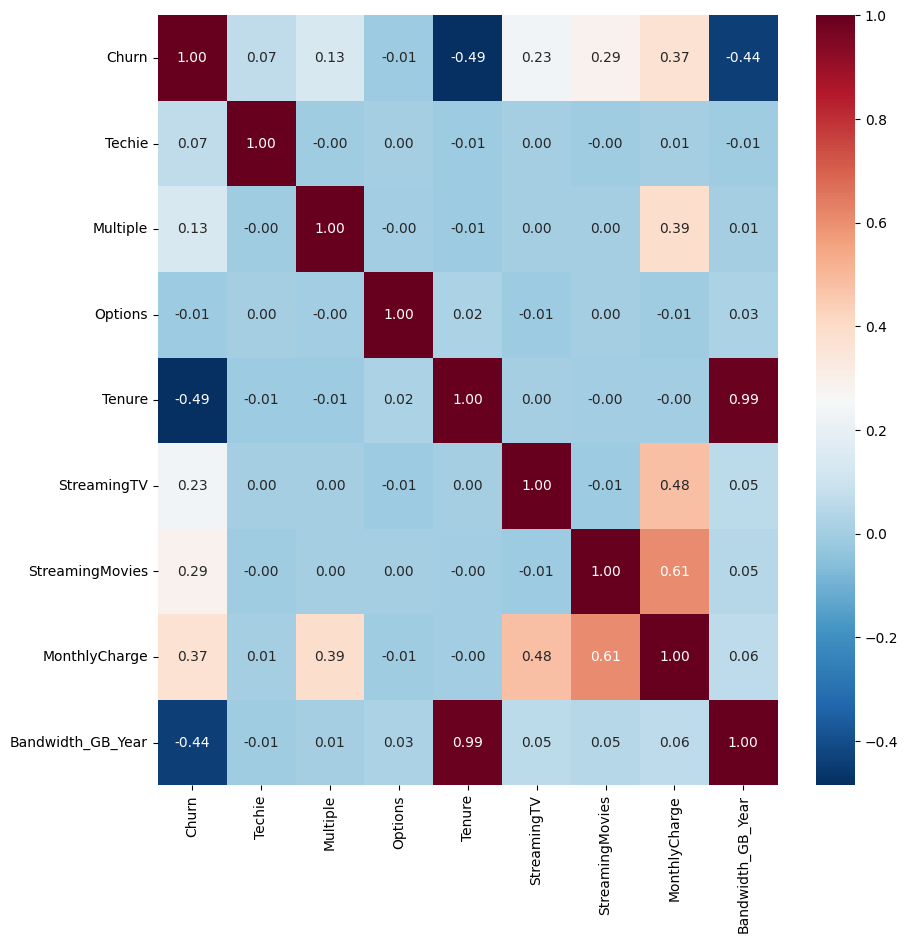

In [125]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(LOGdata.corr(), annot = True, fmt = '.2f',  cmap='RdBu_r')

 ## Univariate graphing of data

Text(0.5, 1.0, 'Contract Type')

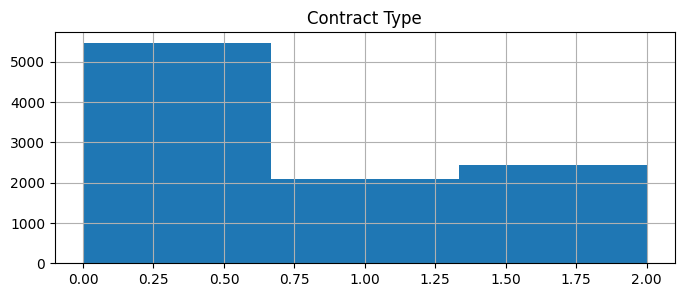

In [126]:
churndata.Contract.hist(bins = 3, figsize=(8,3))
plt.title('Contract Type')

Text(0.5, 1.0, 'Port Modem')

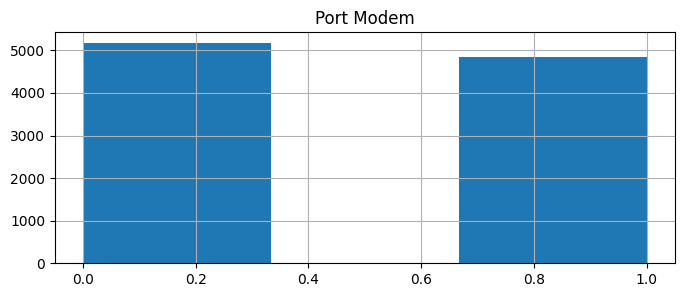

In [127]:
churndata.Port_modem.hist(bins = 3, figsize=(8,3))
plt.title('Port Modem')

Text(0.5, 1.0, 'Tablet')

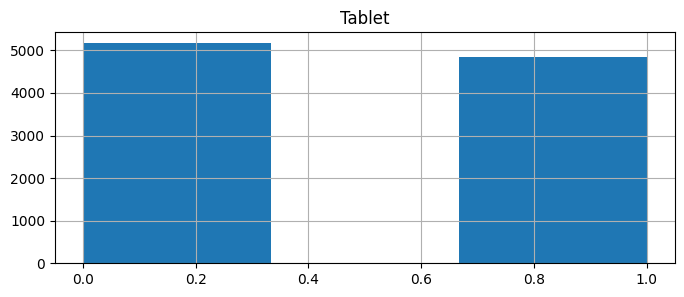

In [128]:
churndata.Port_modem.hist(bins = 3, figsize=(8,3))
plt.title('Tablet')

Text(0.5, 1.0, 'InternetService')

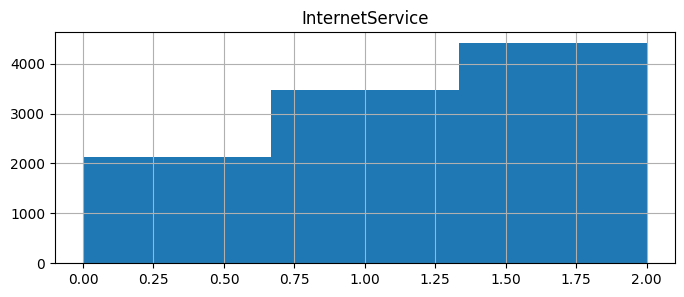

In [129]:
churndata.InternetService.hist(bins = 3, figsize=(8,3))
plt.title('InternetService')

Text(0.5, 1.0, 'Options')

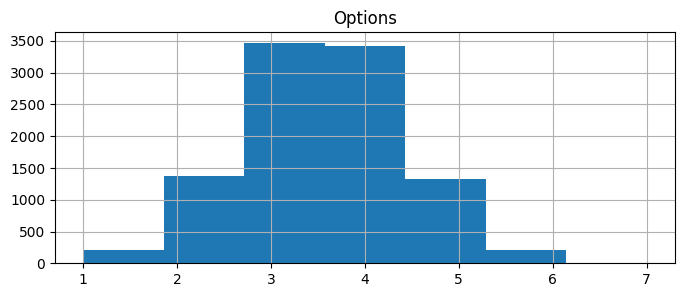

In [130]:
churndata.Options.hist(bins = 7, figsize=(8,3))
plt.title('Options')

In [131]:
churndata.Options

0       4
1       4
2       4
3       5
4       4
       ..
9995    4
9996    4
9997    4
9998    3
9999    3
Name: Options, Length: 10000, dtype: int64

Text(0.5, 1.0, 'Phone')

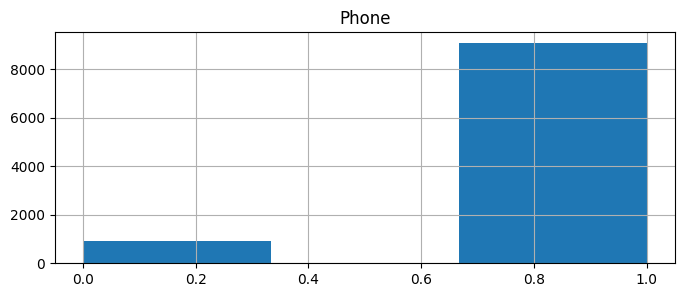

In [132]:
churndata.Phone.hist(bins = 3, figsize=(8,3))
plt.title('Phone')

Text(0.5, 1.0, 'StreamingTV')

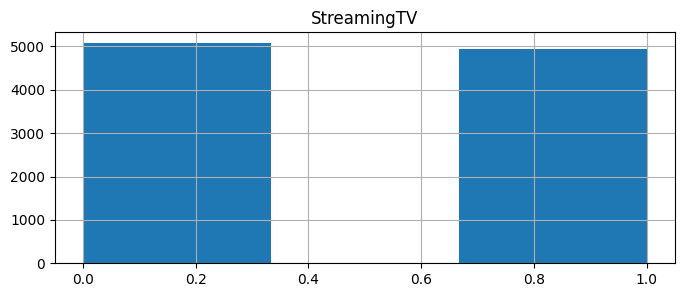

In [133]:
churndata.StreamingTV.hist(bins = 3, figsize=(8,3))
plt.title('StreamingTV')

## Boxplots for all of the items

Text(0.5, 1.0, 'Contacts')

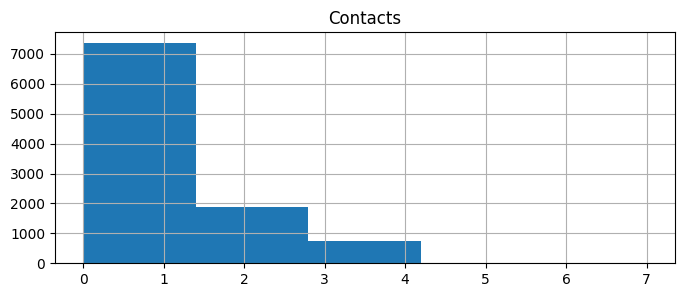

In [134]:
churndata.Contacts.hist(bins = 5, figsize=(8,3))
plt.title('Contacts')

# bivariate graphs

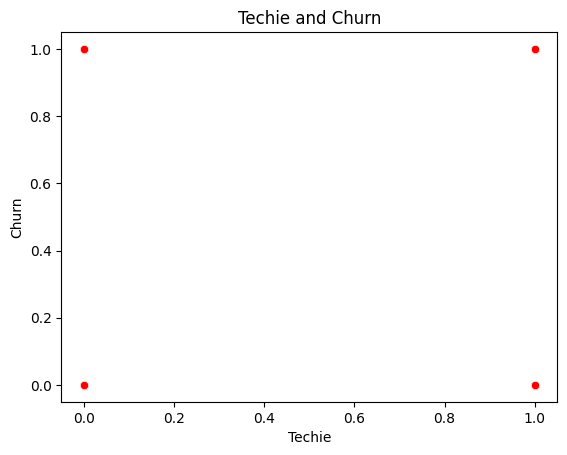

In [135]:
plt.title('Techie and Churn')
sns.scatterplot(x=LOGdata['Techie'], y=LOGdata['Churn'],color='red')
plt.show(); 

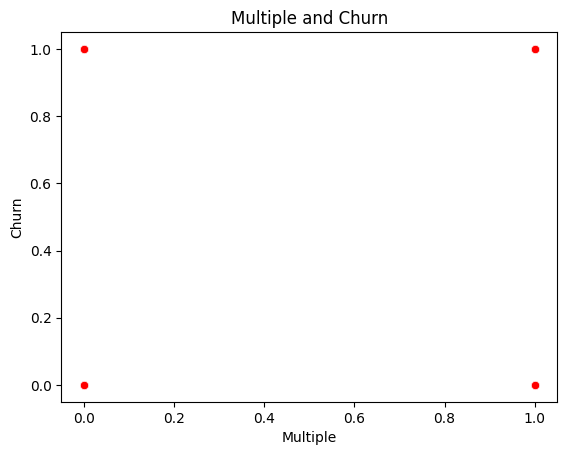

In [136]:
plt.title('Multiple and Churn')
sns.scatterplot(x=LOGdata['Multiple'], y=LOGdata['Churn'],color='red')
plt.show(); 

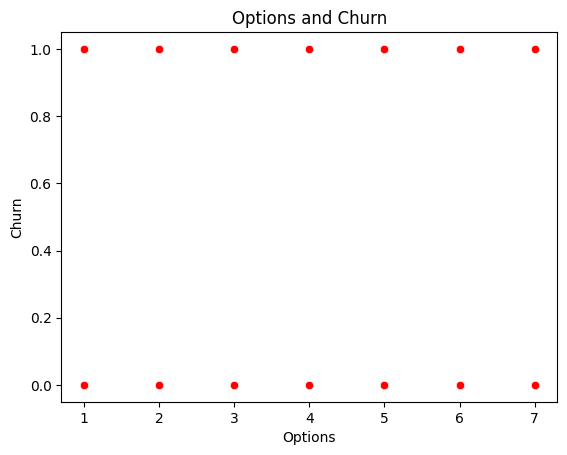

In [137]:
plt.title('Options and Churn')
sns.scatterplot(x=LOGdata['Options'], y=LOGdata['Churn'],color='red')
plt.show(); 

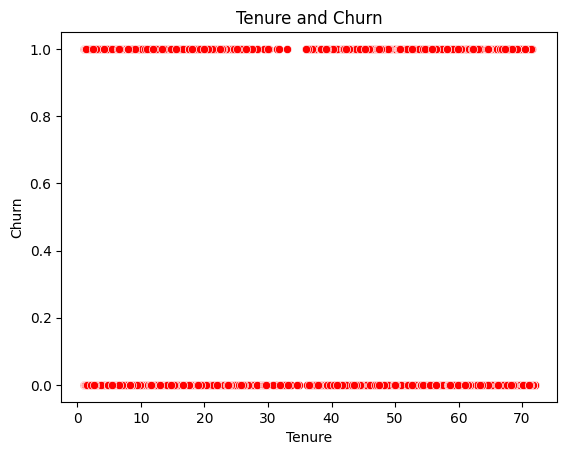

In [138]:
plt.title('Tenure and Churn')
sns.scatterplot(x=LOGdata['Tenure'], y=LOGdata['Churn'],color='red')
plt.show(); 

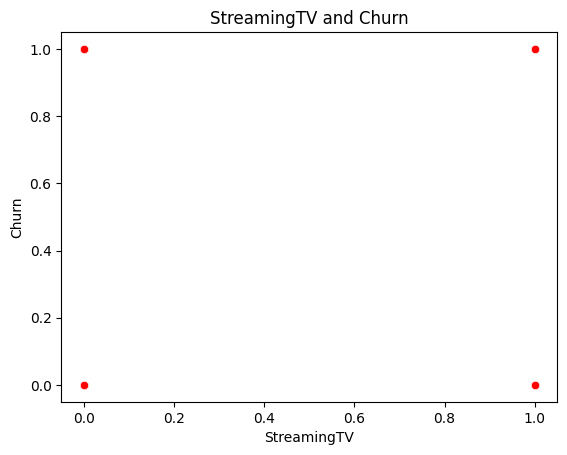

In [139]:
plt.title('StreamingTV and Churn')
sns.scatterplot(x=LOGdata['StreamingTV'], y=LOGdata['Churn'],color='red')
plt.show(); 

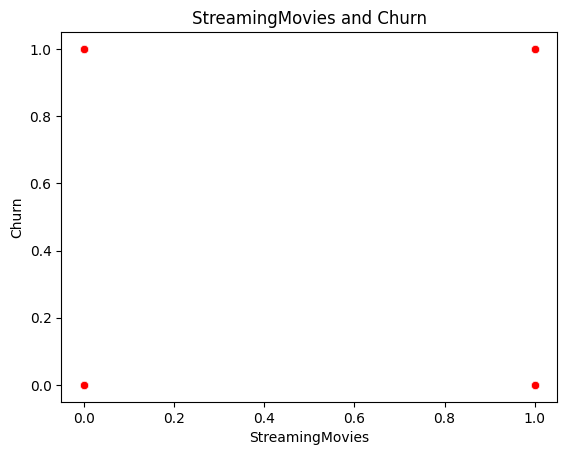

In [140]:
plt.title('StreamingMovies and Churn')
sns.scatterplot(x=LOGdata['StreamingMovies'], y=LOGdata['Churn'],color='red')
plt.show(); 

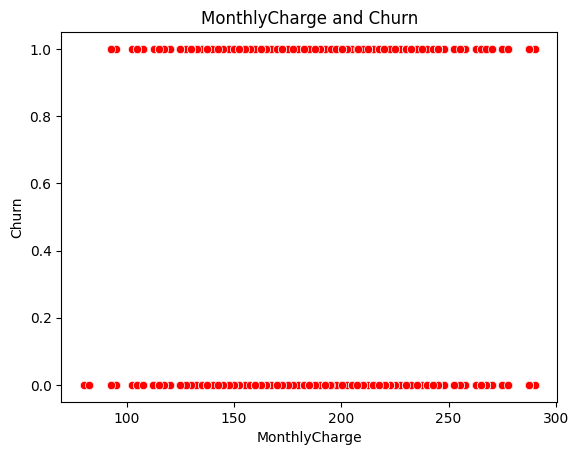

In [141]:
plt.title('MonthlyCharge and Churn')
sns.scatterplot(x=LOGdata['MonthlyCharge'], y=LOGdata['Churn'],color='red')
plt.show(); 

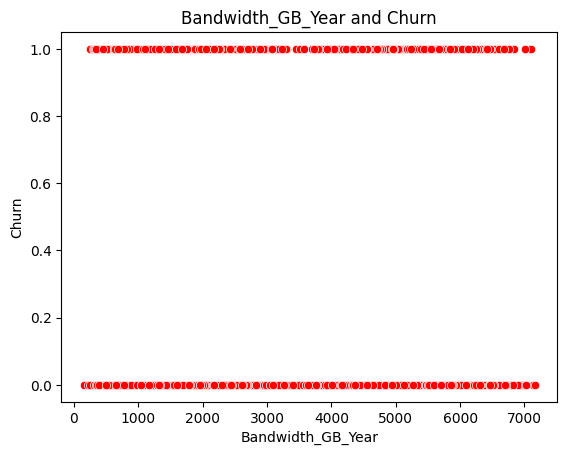

In [142]:
plt.title('Bandwidth_GB_Year and Churn')
sns.scatterplot(x=LOGdata['Bandwidth_GB_Year'], y=LOGdata['Churn'],color='red')
plt.show(); 

# OLS Regression

In [143]:
import matplotlib as plt
import pandas as pd
import numpy as np
from pandas import DataFrame
import pylab
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statistics 
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

LOGdata['intercept'] = 1


## Initial model

In [144]:
X1 = sm.Logit(churndata['Churn'], LOGdata[['Techie',  'Multiple', 'Options', 'Tenure', 'StreamingTV', 'StreamingMovies', 'MonthlyCharge', 'Bandwidth_GB_Year', 'intercept']]).fit()

Optimization terminated successfully.
         Current function value: 0.309917
         Iterations 8


In [145]:
 print(X1.summary())

                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9991
Method:                           MLE   Df Model:                            8
Date:                Wed, 14 Jun 2023   Pseudo R-squ.:                  0.4640
Time:                        23:41:12   Log-Likelihood:                -3099.2
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Techie                0.7316      0.083      8.806      0.000       0.569       0.894
Multiple              0.6651      0.082      8.084      0.000       0.504       0.826
Options              -0.

In [146]:
 LOGdata.head()

Churn  Techie  Multiple  Options     Tenure  StreamingTV  StreamingMovies  \
0      0       0         0        4   6.795513            0                1   
1      1       1         1        4   1.156681            1                1   
2      0       1         1        4  15.754144            0                1   
3      0       1         0        5  17.087227            1                0   
4      1       0         0        4   1.670972            1                0   

   MonthlyCharge  Bandwidth_GB_Year  intercept  
0     172.455519         904.536110          1  
1     242.632554         800.982766          1  
2     159.947583        2054.706961          1  
3     119.956840        2164.579412          1  
4     149.948316         271.493436          1

<Axes: >

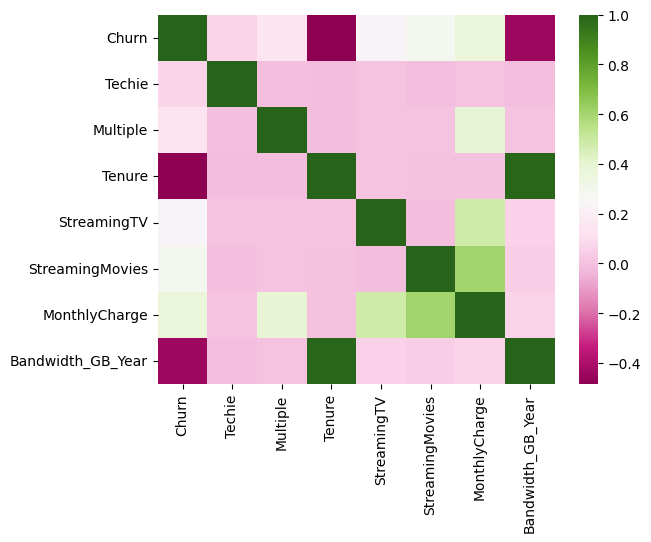

In [147]:
X1data = LOGdata[['Churn', 'Techie',  'Multiple', 'Tenure', 'StreamingTV', 'StreamingMovies', 'MonthlyCharge', 'Bandwidth_GB_Year']]
sns.heatmap(X1data.corr(),xticklabels =X1data.corr().columns, cmap='PiYG' )

## Reduced model

In [148]:
X2 = sm.Logit(churndata['Churn'], LOGdata[['Techie',  'Multiple', 'Tenure', 'StreamingTV', 'StreamingMovies', 'MonthlyCharge', 'Bandwidth_GB_Year', 'intercept']]).fit()
print(X2.summary())

Optimization terminated successfully.
         Current function value: 0.309923
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9992
Method:                           MLE   Df Model:                            7
Date:                Wed, 14 Jun 2023   Pseudo R-squ.:                  0.4640
Time:                        23:41:12   Log-Likelihood:                -3099.2
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Techie                0.7321      0.083      8.813      0.000       0.569       0.895
Multiple

In [149]:
X2data = LOGdata[['Churn', 'Techie',  'Multiple', 'Tenure', 'StreamingTV', 'StreamingMovies', 'MonthlyCharge', 'Bandwidth_GB_Year']]


# Matrix of Correlations for the reduced model

<Axes: >

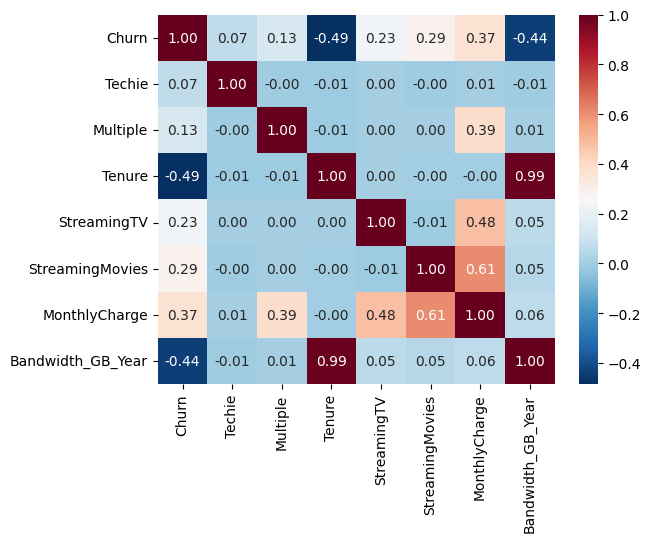

In [150]:
sns.heatmap(X2data.corr(), annot = True, fmt = '.2f',  cmap='RdBu_r')